# Data Generation
In this notebook, we simulate satellite barcode (sBC) reads for beads arranged in a uniform grid as well as using ground-truth positions from the kidney sample in the Slide-seq dataset [Rodriques et al., 2019](https://www.science.org/doi/10.1126/science.aaw1219). Additionally, we demonstrate data generation for the two scenarios included in the supplement - satellite dispersion through e.Coli colonies and anisotropic diffusion.

In [1]:
import numpy as np
import pandas as pd
import anndata
import math
from matplotlib import pyplot as plt

import sys
sys.path.append("../functions/")
import simulate
import visuals

First we define the parameters for the simulations. For all simulations, we need to define the satellite density, the width of the diffusion kernel, and the sample we want to use for our experimental reads per bead distribution. The read per bead distribution determines the sampling depth. For the uniform grid, we also specify the size of area to simulate. By default, we use the distribution from the Slide-seq kidney dataset with a median of 140 reads/ 80 UMI per bead. The experimental distribution of reads per bead is used to simulate the variation of bead qualities encountered in practice. The satellite barcodes are also generated based on an experimental distribution, as we observed that the ~65,000 8-base barcodes occur far from uniformly in practice.

The default parameters can be changed to simulate different sized areas, satellite densities, diffusion constants, or sequencing depths. A variety of bead read distributions based on the Slide-seq kidney are cerebellum tissues samples are available in the <code>data/bead-read-distribution</code> folder. 

In [2]:
# Define parameters for the run
SEED = 42
RNG = np.random.default_rng(SEED)
NUM_PROC = 32

SATELLITES_PER_CM2 = 10**5
SIGMA_UM = 50 # Width of the Gaussian kernel representing satellite diffusion in micro-meters
SAMPLE = 'kidney_140rpb' # Sample to use for the bead-read distribution

BEADS_PER_CM2 = 10**6
AREA_CM2 = 0.1

BEADS = int(BEADS_PER_CM2 * AREA_CM2)
SATELLITES = int(SATELLITES_PER_CM2 * AREA_CM2)
BEADS_PER_EDGE = np.floor(np.sqrt(BEADS)).astype(int)

BEADWIDTH_UM = 10 # Beadwidth in um
EDGE_LENGTH = BEADWIDTH_UM * BEADS_PER_EDGE


SIGMA_BEAD = int(SIGMA_UM / BEADWIDTH_UM) # Sigma in beadwidths

# Factor by which satellites should extended past beads, this reduces edge effects from beads along the
# edge getting fewer reads
SIGMA_BUFFER = 3
EXT_EDGE_LENGTH = EDGE_LENGTH + 2*SIGMA_BUFFER*SIGMA_UM
EXT_RATIO = (EXT_EDGE_LENGTH/EDGE_LENGTH)**2

In [3]:
# Load the bead-quality and barcode overlap distributions
reads_dist = pd.read_csv('../data/bead-quality-distributions/{}.csv'.format(SAMPLE), index_col=0)
overlap_dist = pd.read_csv('../data/barcode-distribution.csv', index_col=0)

### Uniform Grid
First, we simulate data on a 0.1 cm$^2$, uniform grid of 10 $\mu m$ beads.

In [4]:
# Generate a dense grid of beads and random satellites extending slighly beyond the beads
y, x = np.meshgrid(np.arange(0, BEADS_PER_EDGE), np.arange(0, BEADS_PER_EDGE))
y = y.flatten()
x = x.flatten()
bead_coords = BEADWIDTH_UM*np.array([x, y]).T

satellite_coords = EXT_EDGE_LENGTH*RNG.random((int(SATELLITES * EXT_RATIO), 2)) - SIGMA_BUFFER*SIGMA_UM

beads_df = pd.DataFrame(data=bead_coords, columns=['x', 'y'])
satellites_df = pd.DataFrame(data=satellite_coords, columns=['x', 'y'])

In [5]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adata = simulate.generate_reads(SIGMA_UM, bead_coords, satellite_coords,
                                num_proc=NUM_PROC, overlap_dist=overlap_dist['Dist'],
                                reads_dist=reads_dist, scaling=False, seed=SEED)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

100%|██████████| 99856/99856 [00:12<00:00, 7799.65it/s]


Matrix build time: 13.44170618057251


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'spatial_color' as categorical


Next we visualize the simulated data, showing reads from individual colonies. Note that due to the distribution of bead qualities, adjacent beads may differ significantly in the number of reads that are sequenced from the same satellite. However the proportion of reads from each nearby colony remains similar, allowing us to reconstruct their positions.

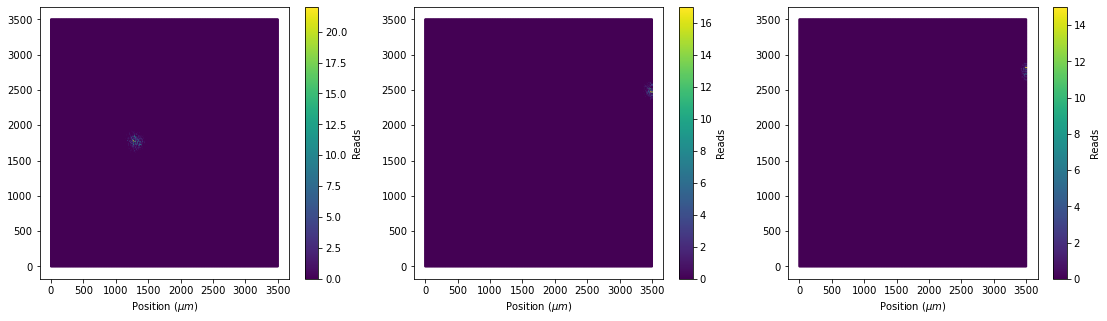

In [6]:
# Visualize reads from a few satellites
visuals.satellite_barcode_counts(adata, n_colonies=3, edge_length_um=BEADWIDTH_UM * BEADS_PER_EDGE, step_um=500)

### Slide-seq Kidney Positions

Here we repeat the data generation process using ground-truth positions from the kidney sample in the Slide-seq dataset.

In [7]:
# Generate the dataframes of bead and satellite positions
kidney = pd.read_csv('../data/slideseq-positions/kidney_positions.csv', index_col=0)
bead_coords = np.array([kidney['x'], kidney['y']]).T

satellite_coords = EXT_EDGE_LENGTH*RNG.random((int(SATELLITES * EXT_RATIO), 2)) - SIGMA_BUFFER*SIGMA_UM

beads_df = pd.DataFrame(data=bead_coords, columns=['x', 'y'])
satellites_df = pd.DataFrame(data=satellite_coords, columns=['x', 'y'])

In [8]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adata = simulate.generate_reads(SIGMA_UM, bead_coords, satellite_coords,
                                num_proc=NUM_PROC, overlap_dist=overlap_dist['Dist'],
                                reads_dist=reads_dist, scaling=False, seed=SEED)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}_slideseq_kidney_positions.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

100%|██████████| 30758/30758 [00:10<00:00, 2870.50it/s]


Matrix build time: 11.855396270751953


... storing 'spatial_color' as categorical


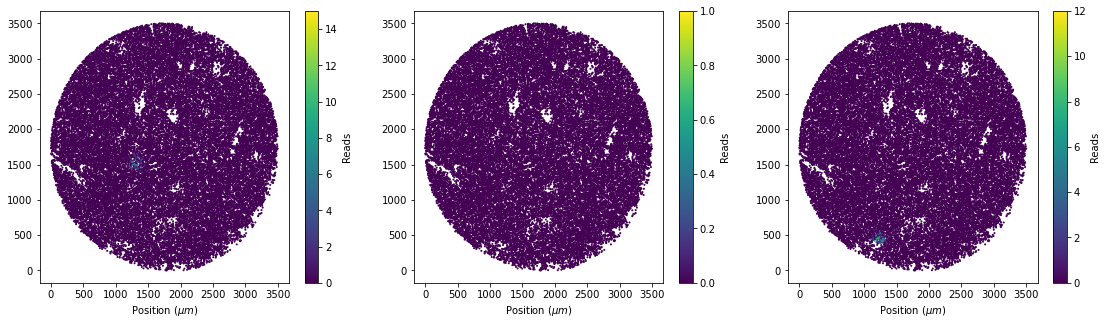

In [9]:
# Visualize reads from a few satellites
visuals.satellite_barcode_counts(adata, n_colonies=3, edge_length_um=BEADWIDTH_UM*BEADS_PER_EDGE, step_um=500)

## Supplemental Methods
In the supplement, we show results for two additional scenarios - using e.Coli colonies to disperse satellite barcodes and standard satellite dispersion with anisotropic diffusion. Below we show how to simulate data to reproduce those results. While we reuse most of the parameters from above, simulating satellite dispersion from bacterial colonies introduces a new parameter of the proportion of the surface covered by bacterial colonies.

In [10]:
# Define parameters for the supplemental methods
PROP_COVERAGE = 0.9

### Bacterial Colonies as Satellites

We suggest several methods for dispersing satellite barcodes. The figures in the main text simulate satellite barcode generation through gel PCR, where we can potentially generate over 100,000 satellites which may overlap in space. In the supplement, we discuss an alternative generation method using e.Coli colonies. The e.Coli colonies introduce several challenges, including that they may have irregular shapes, we may only be able to generate tens of throusands per square centimeter, and they will not be able to overlap in space as they grow in a single layer.

Here we generate data for irregular e.Coli colonies on a dense, uniform grid to recreate the reconstructions shown in the supplement.

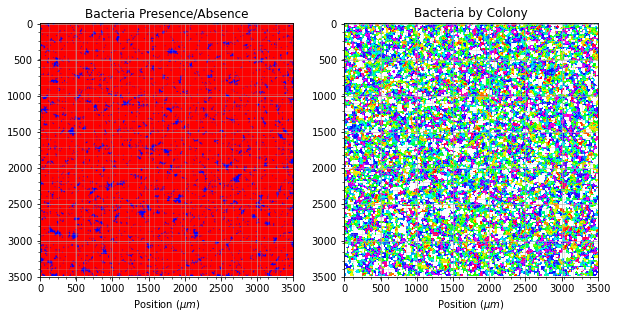

In [12]:
# Simulate and visualize the e.Coli colonies
colony_grid = simulate.grow_colonies(BEADS_PER_EDGE, SATELLITES, SIGMA_UM, BEADWIDTH_UM, PROP_COVERAGE=PROP_COVERAGE,
                                     seed=SEED)
visuals.colony_grid(colony_grid, beadwidth=BEADWIDTH_UM, step_um=500)

In [13]:
# Generate an anndata with satellite barcode counts stored in the read matrix
adata = simulate.generate_bacterial_reads(colony_grid=colony_grid, sigma_um=SIGMA_UM, beadwidth_um=BEADWIDTH_UM,
                                          reads_dist=reads_dist, overlaps_dist=overlap_dist['Dist'],
                                          n_sigma_buffer = SIGMA_BUFFER, seed=SEED)

adata.write_h5ad('../data/adata/{}_satellites={}_sigma={}_irregular_colonies.h5ad'.format(SAMPLE, SATELLITES_PER_CM2, SIGMA_UM))

  0%|          | 32/99856 [00:00<05:17, 314.83it/s]

Generated beads.
Generating reads...


100%|██████████| 99856/99856 [05:26<00:00, 305.63it/s]


Generated expression matrix.
Generated anndata.
Adding metadata...


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'spatial_color' as categorical


Finished read generation


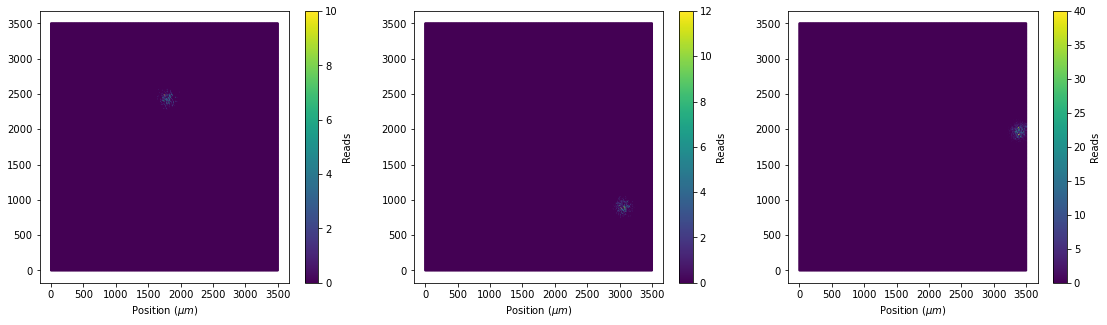

In [14]:
# Visualize reads from a few satellites
visuals.satellite_barcode_counts(adata, n_colonies=3, edge_length_um=EDGE_LENGTH, step_um=500)